# Develop methods to immediately produce batches for ANN training

In [1]:
import Interface as I

/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/model_data_base/distributed_lock.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


trying to connect to distributed locking server {'config': {'hosts': 'somalogin02-hs:33333'}, 'type': 'zookeeper'}
success!
Current version: heads/master+0.g4701d9b.dirty
Current pid: 134862


/gpfs/soma_fs/scratch/meulemeester/anaconda_isf3/lib/python3.8/site-packages/pandas_msgpack-0.1.4+14.gfcb0471-py3.8-linux-x86_64.egg/pandas_msgpack/packers.py:78: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Timestamp, Period, Series, DataFrame,  # noqa


Loading mechanisms:
setting up local multiprocessing framework ... done


Loaded modules with __version__ attribute are:
IPython: 7.19.0, Interface: heads/master+0.g4701d9b.dirty, PIL: 8.2.0, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.10.2, bluepyopt: 1.9.126, bottleneck: 1.3.2, cffi: 1.14.3, click: 7.1.2, cloudpickle: 1.6.0, colorama: 0.4.4, csv: 1.0, ctypes: 1.1.0, cycler: 0.10.0, cytoolz: 0.11.0, dask: 2.30.0, dateutil: 2.8.1, deap: 1.3, decimal: 1.70, decorator: 4.4.2, distributed: 2.30.1, distutils: 3.8.5, fsspec: 0.8.3, future: 0.18.2, ipykernel: 5.3.4, ipython_genutils: 0.2.0, ipywidgets: 7.5.1, jedi: 0.17.1, jinja2: 2.11.2, joblib: 0.17.0, json: 2.0.9, jupyter_client: 6.1.7, jupyter_core: 4.6.3, kazoo: 2.8.0, kiwisolver: 1.3.0, logging: 0.5.1.2, markupsafe: 1.1.1, matplotlib: 3.3.2, mkl: 2.3.0, neuron: 7.8.2, numexpr: 2.7.1, numpy: 1.19.2, pandas: 1.1.3, pandas_msgpack: 0.1.4+14.gfcb0471.dirty, parameters: 0.2.1, parso: 

/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/Interface.py:183: UserWarning:

The source folder has uncommited changes!



In [2]:
# Dinuka and Chantal's "default" database to test bottleneck models
mdb = I.ModelDataBase('/gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb')
mdb = mdb['example_in_distribution_simulation_1ms_INH_adapt_inh_v2.6_shift-3_offset_445_280000_trials']

In [3]:
mdb.metadata['simresult_path'].keys() #[('synapse_activation_binned_v2', '365_505_1', 'EI__section/branch_bin')].listdir()
# maybe add a key to metadata that tells if it was created with mdb_init, and which init
# there is a simulation init, a batches init

dict_keys(['dumper', 'time', 'metadata_creation_time', 'conda_list', 'module_versions', 'history', 'hostname', 'version', 'full-revisionid', 'dirty', 'error'])

"""Up to spike times, these are all default simualtion output dirs
All others are data without specific format.
look what dirs simrun_init generates
maybe add labels for create_batches initialiser, these also create specific folders
"""

In [5]:
sti = mdb['spike_times'].index[0]
cell = I.simrun_simtrail_to_cell_object(mdb, sti)

/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/single_cell_parser/__init__.py:85: UserWarning:

Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs

/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/single_cell_parser/cell_parser.py:122: UserWarning:

Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs

Connection dropped: socket connection broken
Transition to CONNECTING


# voltage

In [6]:
def get_segments_in_section(section_id):
    """Given a section number, this method returns the x value of each segment in this section"""
    xs = [segment.x for segment in cell.sections[section_id]]
    return xs

# if x coordinate of segment is between bin limits, it belongs to that bin

def get_bin_limits(section_id, section_distances_df):
    n_bins = section_distances_df.iloc[section_id]["n_bins"]
    n_bins = 1 if n_bins == 'Soma' else n_bins
    bin_limits = [i/n_bins for i in range(n_bins)]
    bin_limits.append(1)
    return bin_limits

def segments_to_bins(section_id, section_distances_df):
    bins = []
    bin_limits = get_bin_limits(section_id, section_distances_df)
    segments = get_segments_in_section(section_id)
    for segment in segments:
        for bin in range(len(bin_limits)-1):
            if bin_limits[bin] < segment <= bin_limits[bin+1]:
                bins.append(bin)
    return bins

def bin_voltages_in_section(cell, section_id, section_distances_df):
    binned_segments = segments_to_bins(section_id, section_distances_df)
    n_bins = binned_segments[-1]+1
    section = cell.sections[section_id]
    binned_voltages= [None]*n_bins
    voltages = section.recVList
    n_time_points = len(cell.t)
    for bin in range(n_bins):
        segment_idxs = I.np.where([e == bin for e in binned_segments])[0]
        segment_voltage_traces = [voltages[i] for i in segment_idxs]
        max_voltages_in_bin = []
        for t in range(n_time_points):
            max_voltage_in_bin = max([segment_voltage_trace[t] for segment_voltage_trace in segment_voltage_traces])
            max_voltages_in_bin.append(max_voltage_in_bin)
        binned_voltages[bin]=max_voltages_in_bin
    return I.np.array(binned_voltages)


# print(bin_voltages_in_section(cell, 167, section_distances_df))

Session has expired


In [65]:
def get_point_per_bin(section, section_id, section_distances_df):
    """Given a Cell.section object, this method returns one point per spatial bin in this section.
    Useful for plotting.

    Args:
        section (Cell.section): The Cell section
        section_id (int): Index of the section
        section_distances_df (pd.DataFrame): Dataframe describing the amount of spatial bins per section.

    Returns:
        _type_: _description_
    """
    all_points_in_section = section.pts
    n_bins = section_distances_df.iloc[section_id]['n_bins']
    n_bins = 1 if n_bins == "Soma" else n_bins
    jump=len(all_points_in_section)//n_bins
    pts_per_bin = [all_points_in_section[jump*i] for i in range(n_bins)]
    return pts_per_bin

In [8]:
from model_data_base.mdb_initializers.prepare_ANN_batches import get_binsize

def get_section_distances_df_from_cell(cell, spatial_binsize_goal=50):
    """Given a Cell object, produce the section_distances_dataframe, i.e. a DataFrame with the following information:
    - Section indices as index
    - amount of bins per section
    - Size of the bins in this section
    - Min and max distance from soma

    Args:
        cell (Cell): The Cell object
        binsize_goal (int | float): The desired size of the spatial binning. Defaults to 50 microns.

    Returns:
        pd.DataFrame: The section distances dataframe describing size and location of the section, amount of bins and bin sizes
    """
    sections_min_dist = [I.sca.synanalysis.compute_distance_to_soma(sec, 0) for sec in cell.sections]
    sections_max_dist = [I.sca.synanalysis.compute_distance_to_soma(sec, 1) for sec in cell.sections]
    binsize = [get_binsize(length=s_ma-s_mi, binsize_goal=spatial_binsize_goal)[0] if (cell.sections[lv].label != 'Soma') else 'Soma' for lv, (s_mi, s_ma) in enumerate(zip(sections_min_dist, sections_max_dist))]
    n_bins = [get_binsize(length=s_ma-s_mi, binsize_goal=spatial_binsize_goal)[1] if (cell.sections[lv].label != 'Soma') else 'Soma' for lv, (s_mi, s_ma) in enumerate(zip(sections_min_dist, sections_max_dist))]
    # bin_borders = [I.np.linspace(s_mi, s_ma, num = n_bins) if not isinstance(n_bins, str) else 'Soma' for s_mi, s_ma, n_bins in 
    #               zip(sections_min_dist, sections_max_dist, n_bins)]  # unused
    section_distances_df = I.pd.DataFrame({'min_': sections_min_dist, 'max_': sections_max_dist, 'n_bins': n_bins, 'binsize': binsize})
    return section_distances_df

def bin_points_and_voltage(cell, section_distances_df=None, spatial_binsize_goal=50):
    """Given a cell object, this method calculates the binned spatial points and their corresponding voltage traces.

    Args:
        cell (Cell): The cell object

    Returns:
        (pd.Dataframe, np.array): the cell morphology as a pandas dataframe, and a nested numpy array of voltage traces, where axis0 is the spatial bin, and axis1 is time
    """
    section_distances_df = get_section_distances_df_from_cell(cell, spatial_binsize_goal=spatial_binsize_goal) if section_distances_df is None else section_distances_df
    points = []
    vms = []
    for sec_n, sec in enumerate(cell.sections):
        if sec.label in ['AIS', 'Myelin']:
            continue
        pts = get_point_per_bin(sec, sec_n, section_distances_df)
        binned_vms = bin_voltages_in_section(section_distances_df=section_distances_df, section_id=sec_n, cell=cell)
        for i, pt in enumerate(pts):
            # Points within the same section
            x = pt[0]
            y = pt[1]
            z = pt[2]
            d = sec.diamList[i]
            points.append([x, y, z, d, sec_n])
            vms.append(binned_vms[i])
            
    morphology = I.pd.DataFrame(points, columns=['x','y','z','diameter','section'])
    return morphology, I.np.array(vms)

In [9]:
section_distances_df = get_section_distances_df_from_cell(cell)
section_distances_df

,min_,max_,n_bins,binsize
0,0.000000,0.000000,Soma,Soma
1,0.000000,16.346397,1,16.3464
2,16.346397,41.192804,1,24.8464
3,41.192804,168.373734,3,42.3936
4,41.192804,100.616834,1,59.424
...,...,...,...,...
114,37.202526,177.783162,3,46.8602
115,37.202526,221.022591,4,45.955
116,0.000000,20.000000,1,20
117,20.000000,50.000000,1,30


In [10]:
points, binned_voltages = bin_points_and_voltage(cell, section_distances_df)

test if number of bins is the same

In [11]:
I.np.array(binned_voltages).shape

(238, 13802)

assumption: step size is 0.025. For 1ms resolution, take every other 40th voltage

In [12]:
binned_voltages[:,::40] # this would be the array we save

array([[-75.        , -75.3163863 , -75.23815758, ..., -70.22565453,
        -70.52584214, -70.8884742 ],
       [-75.        , -75.32481438, -75.25753134, ..., -69.98825726,
        -70.3369982 , -70.73660382],
       [-75.        , -75.35743418, -75.33670632, ..., -68.91055389,
        -69.29542183, -69.86293596],
       ...,
       [-75.        , -75.48614889, -75.85949819, ..., -36.5800708 ,
        -39.05350762, -31.69480963],
       [-75.        , -75.49185348, -75.9212254 , ..., -30.63862315,
        -33.44639711, -30.87711729],
       [-75.        , -75.49258216, -75.94150768, ..., -24.73851706,
        -27.95482405, -28.20625704]])

In [78]:
section_distances_df = get_section_distances_df_from_cell(cell)

def assert_same_stepsize(t_array):
    dts = I.np.ediff1d(t_array)
    I.np.testing.assert_allclose(dts, I.np.mean(dts), err_msg="Stepsizes are not the same!")

def get_voltage_array_from_cell(cell, section_distances_df, min_time, max_time, temporal_resolution=1):
    """_summary_

    Args:
        cell (Cell): _description_
        section_distances_df (pd.DataFrame): _description_
        min_time (float/int): _description_
        max_time (float/int): _description_
        temporal_resolution (int, optional): Required resolution in ms. Defaults to 1 ms.
        spatial_binsize_goal (int | float): Desired size of the spatial bins in micrometer. Defaults to 50µm.

    Returns:
        np.array: 2D array
    """
    assert_same_stepsize(cell.t)
    dt = cell.t[1] - cell.t[0]  # most often 0.025
    every_other_index = int(temporal_resolution / dt)
    if max_time > cell.t[-1]:
        print("Warning: Specified max_time of {0} is larger than simulation time of {1}. Voltage traces can only be calcualted until {1} ms".format(max_time, cell.t[-1]))
    # assert step size of 0.025
    # TODO: redundant if we test for equal stepsize and specify resolution. Test if this can be omitted.
    I.np.testing.assert_almost_equal(cell.t[1], 0.025)
    I.np.testing.assert_almost_equal(cell.t[40], 1)

    _, vms = bin_points_and_voltage(cell, section_distances_df)
    return vms[:,::every_other_index][:,min_time:max_time]

In [79]:
print(cell.t)
get_voltage_array_from_cell(cell, section_distances_df, 0, 445+60, 1).shape

[0.00000e+00 2.50000e-02 5.00000e-02 ... 3.44975e+02 3.45000e+02
 3.45025e+02]


(238, 346)

# synapse activation

In [15]:
from model_data_base.mdb_initializers.prepare_ANN_batches import get_synapse_activation_array_weighted, augment_synapse_activation_df_with_branch_bin, get_spatial_bin_names

In [16]:
sa_ = cell.get_synapse_activation_dataframe()
sa_

,synapse_type,synapse_ID,soma_distance,section_ID,section_pt_ID,dendrite_label,0,1,2,3,...,10,11,12,13,14,15,16,17,18,19
0,L1_B2,0,1091.840740,107,5,ApicalDendrite,978.468095,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,L1_B3,0,1151.063319,99,63,ApicalDendrite,398.793062,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,L1_B3,1,1144.719493,107,25,ApicalDendrite,905.502800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,L1_B4,0,1181.899132,104,41,ApicalDendrite,238.825511,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,L1_C2,0,1149.329748,107,28,ApicalDendrite,119.625449,236.133369,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,VPM_C2,1876,203.393370,115,141,Dendrite,183.261231,913.735965,1075.362194,1138.079887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,VPM_C2,1877,207.103670,115,144,Dendrite,183.261231,516.637736,596.983125,913.735965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,VPM_C2,1878,210.916662,115,147,Dendrite,596.983125,748.618113,1075.362194,1122.427611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,VPM_C2,1879,212.017738,115,148,Dendrite,748.618113,913.735965,1075.362194,1138.079887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
sa_ = augment_synapse_activation_df_with_branch_bin(sa_, section_distances_df, synaptic_weight_dict=None)
sa_

,synapse_type,synapse_ID,soma_distance,section_ID,section_pt_ID,dendrite_label,0,1,2,3,...,14,15,16,17,18,19,branch_bin,section/branch_bin,celltype,EI
0,L1_B2,0,1091.840740,107,5,ApicalDendrite,978.468095,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,107/1,L1,INH
0,L1_B3,0,1151.063319,99,63,ApicalDendrite,398.793062,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,99/3,L1,INH
0,L1_B3,1,1144.719493,107,25,ApicalDendrite,905.502800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,107/2,L1,INH
0,L1_B4,0,1181.899132,104,41,ApicalDendrite,238.825511,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,104/3,L1,INH
0,L1_C2,0,1149.329748,107,28,ApicalDendrite,119.625449,236.133369,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,107/2,L1,INH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,VPM_C2,1876,203.393370,115,141,Dendrite,183.261231,913.735965,1075.362194,1138.079887,...,NaN,NaN,NaN,NaN,NaN,NaN,4,115/4,VPM,EXC
0,VPM_C2,1877,207.103670,115,144,Dendrite,183.261231,516.637736,596.983125,913.735965,...,NaN,NaN,NaN,NaN,NaN,NaN,4,115/4,VPM,EXC
0,VPM_C2,1878,210.916662,115,147,Dendrite,596.983125,748.618113,1075.362194,1122.427611,...,NaN,NaN,NaN,NaN,NaN,NaN,4,115/4,VPM,EXC
0,VPM_C2,1879,212.017738,115,148,Dendrite,748.618113,913.735965,1075.362194,1138.079887,...,NaN,NaN,NaN,NaN,NaN,NaN,4,115/4,VPM,EXC


In [18]:
selected_stis = [0] # default index if synapse activation df is retrived by cell.get_synapse_activation_dataframe()
min_time = 0
max_time = 445+60
bin_size = 1
spatial_bin_names = get_spatial_bin_names(section_distances_df)
arr = get_synapse_activation_array_weighted(sa_, selected_stis, spatial_bin_names = spatial_bin_names,
                                        min_time = min_time, max_time = max_time, bin_size = bin_size,
                                        use_weights = None)  

In [19]:
arr.shape # trials x celltypes x spatial bins x temporal bins

(1, 2, 260, 505)

Ignore Myelin and AIS

In [20]:
sections_to_keep = [i for i,sec in enumerate(cell.sections) if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']]

In [21]:
spatial_bin_indices_to_keep = [i for i,sb in enumerate(spatial_bin_names) if int(sb.split('/')[0]) in sections_to_keep]

In [22]:
len(spatial_bin_indices_to_keep)

238

Augment synaptic activation with branch information

In [23]:
syn_weights = None
sa_ = augment_synapse_activation_df_with_branch_bin(sa_, section_distances_df, syn_weights)
weighed_augmented_sa = get_synapse_activation_array_weighted(sa_, selected_stis, spatial_bin_names = spatial_bin_names,
                                        min_time = min_time, max_time = max_time, bin_size = bin_size,
                                        use_weights = syn_weights is not None)    

In [24]:
weighed_augmented_sa[:,:,spatial_bin_indices_to_keep,:].shape

(1, 2, 238, 505)

In [25]:
from model_data_base.mdb_initializers.prepare_ANN_batches import get_synapse_activation_array_weighted,augment_synapse_activation_df_with_branch_bin,get_spatial_bin_names
def get_synapse_activation_array_from_cell(cell, section_distances_df, 
                                           min_time = None, max_time = None, bin_size = None, syn_weights = None):
    if not bin_size == 1:
        raise NotImplementedError()
        
    selected_stis = [0] # default index if synapse activation df is retrived by cell.get_synapse_activation_dataframe()
    #min_time = 0
    #max_time = 445+60
    #bin_size = 1
    spatial_bin_names = get_spatial_bin_names(section_distances_df)
    
    arr = get_synapse_activation_array_weighted(sa_, selected_stis, spatial_bin_names = spatial_bin_names,
                                            min_time = min_time, max_time = max_time, bin_size = bin_size,
                                            use_weights = syn_weights is not None)
    sections_to_keep = [i for i,sec in enumerate(cell.sections) if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']]
    spatial_bin_indices_to_keep = [i for i,sb in enumerate(spatial_bin_names) if int(sb.split('/')[0]) in sections_to_keep]
    return arr[:,:,spatial_bin_indices_to_keep,min_time:max_time]

In [26]:
get_synapse_activation_array_from_cell(cell, section_distances_df, 0, 445, 1).shape

(1, 2, 238, 445)

# Spike times

In [27]:
from project_specific_ipynb_code.hot_zone import get_main_bifurcation_section

In [28]:
sec = get_main_bifurcation_section(cell)

In [29]:
v_dist = I.np.array(sec.recVList[-1])
v_soma = I.np.array(cell.soma.recVList[0])
t = I.np.array(cell.t)

In [30]:
get_synapse_activation_array_weighted(sa_, selected_stis = [0], spatial_bin_names = spatial_bin_names,
                                 min_time = 0, max_time = 600, bin_size = 1, 
                                 use_weights = False)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [31]:
section_distances_df['label'] = I.pd.Series(section_distances_df.index).apply(lambda x: cell.sections[x].label)

In [32]:
from single_cell_analyzer.membrane_potential_analysis import simple_spike_detection 
# collect spike times for all tirals
soma_AP_times = simple_spike_detection(t, v_soma, mode = 'regular', threshold = 0)
Ca_AP_times = simple_spike_detection(t, v_dist, mode = 'regular', threshold = -30)
soma_AP_times

[15.999999999999625,
 23.724999999999188,
 30.449999999998806,
 165.79999999998614,
 181.62499999997175,
 298.3249999998656,
 319.37499999984647]

In [33]:
# make df for all trials 
Ca_AP_times_df = I.pd.DataFrame(Ca_AP_times).T
soma_AP_times_df = I.pd.DataFrame(soma_AP_times).T

In [34]:
soma_AP_times

[15.999999999999625,
 23.724999999999188,
 30.449999999998806,
 165.79999999998614,
 181.62499999997175,
 298.3249999998656,
 319.37499999984647]

# Put it all together
Run simulation and save binned AP and ISI for Ca-zone and soma, as well as binned voltage traces with 1ms (by default) resolution

In [52]:
def compute_ISI_from_spiketime_list(st, min_time=0, max_time=505, temporal_resolution=1):
    """Given an array of spike times, this method returns a list of size (:@param max_time: - :@param_min_time:)//:@param time_step:,
    where each time step gives the amount of time since the last spike in ms.
    Do not provide a pd.Series or pd.DataFrame here. For that, use :@function model_database.mdb_initialisers.prepare_ANN_batches.compute_ISI_from_st: instead.

    Args:
        st (array): _description_
        min_time (int, optional): Min time of time window in ms. Defaults to 0.
        max_time (int, optional): Max time of time window in ms. Defaults to 505.
        time_step (int, optional): Timestep in ms. Defaults to 1.

    Returns:
        _type_: _description_
    """
    assert type(st) not in (I.pd.DataFrame, I.pd.Series), "This methods is for arrays or lists. When using a pandas Dataframe or Series, use model_database.mdb_initialisers.prepare_ANN_batches.compute_ISI_from_st instead."
    assert type(st) in (list, I.np.array), "Please provide a list or array as spike times."
    st = [e for e in st if min_time <= e <= max_time]
    ISI = []
    for timepoint in I.np.arange(min_time, max_time, temporal_resolution):
        st_ = [e for e in st if e < timepoint]
        if st_:
            max_spike_time_before_timepoint = max(st_)
            ISI.append(timepoint - max_spike_time_before_timepoint)
        else:
            ISI.append(timepoint)
    return ISI

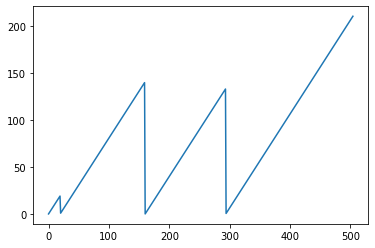

In [ ]:
%matplotlib inline
I.plt.plot(compute_ISI_from_spiketime_list(Ca_AP_times))
I.plt.axvline([Ca_AP_times])

In [59]:
%reload_ext autoreload
%autoreload 2

from Interface import scp, os, dask, np
from simrun2.rerun_mdb import synapse_activation_df_to_roberts_synapse_activation
import time
from model_data_base.mdb_initializers.prepare_ANN_batches import compute_AP_array, compute_ISI_array, spike_times_to_onehot, compute_ISI_from_st_list
from single_cell_analyzer.membrane_potential_analysis import simple_spike_detection 


def _evoked_activity(mdb, stis, outdir,
                     neuron_param_modify_functions = [],
                     network_param_modify_functions = [],
                     synapse_activation_modify_functions = [],
                     additional_network_params = [],
                     recreate_cell_every_run = None,
                     parameterfiles = None,
                     neuron_folder = None,
                     network_folder = None,
                     sa = None,
                     temporal_resolution=1,
                     min_time=0, max_time=445+60):
    """This method runs simulations defined by the given arguments.
    For each entry in stis, a trial is run.
    The following data is then converted to a batch format with coarse resolution, optimised for ANN training:
    - Voltage traces at each spatial bin

    Args:
        mdb (_type_): _description_
        stis (_type_): _description_
        outdir (_type_): _description_
        neuron_param_modify_functions (list, optional): _description_. Defaults to [].
        network_param_modify_functions (list, optional): _description_. Defaults to [].
        synapse_activation_modify_functions (list, optional): _description_. Defaults to [].
        additional_network_params (list, optional): _description_. Defaults to [].
        recreate_cell_every_run (_type_, optional): _description_. Defaults to None.
        parameterfiles (_type_, optional): _description_. Defaults to None.
        neuron_folder (_type_, optional): _description_. Defaults to None.
        network_folder (_type_, optional): _description_. Defaults to None.
        sa (_type_, optional): _description_. Defaults to None.
        temporal_resolution (int, optional): _description_. Defaults to 1.
        min_time (int, optional): _description_. Defaults to 0.
        max_time (_type_, optional): _description_. Defaults to 445+60.

    Raises:
        NotImplementedError: _description_
        NotImplementedError: _description_
    """
    print('saving to ', outdir)
    import neuron
    h = neuron.h
    sti_bases = [s[:s.rfind('/')] for s in stis]
    if not len(set(sti_bases)) == 1:
        raise NotImplementedError
    sti_base = sti_bases[0]
    sa = sa.content
    print('start loading synapse activations')
    sa = sa.loc[stis].compute(get = dask.get)
    print('done loading synapse activations')    
    sa = {s:g for s,g in sa.groupby(sa.index)}
    
    outdir_absolute = os.path.join(outdir, sti_base)
    if not os.path.exists(outdir_absolute):
        os.makedirs(outdir_absolute)
    
    parameterfiles = parameterfiles.loc[stis]
    parameterfiles = parameterfiles.drop_duplicates()
    if not len(parameterfiles) == 1:
        raise NotImplementedError()
        
    neuron_name = parameterfiles.iloc[0].hash_neuron
    neuron_param = scp.build_parameters(neuron_folder.join(neuron_name))
    network_name = parameterfiles.iloc[0].hash_network
    network_param = scp.build_parameters(network_folder.join(network_name)) 
    additional_network_params = [scp.build_parameters(p) for p in additional_network_params]
    for fun in network_param_modify_functions:
        network_param = fun(network_param)
    for fun in neuron_param_modify_functions:
        neuron_param = fun(neuron_param)
            
    scp.load_NMODL_parameters(neuron_param)
    scp.load_NMODL_parameters(network_param)    
    cell = scp.create_cell(neuron_param.neuron, scaleFunc=None)
    
    bifur_sec = get_main_bifurcation_section(cell)
    #vTraces = []
    #tTraces = []
    #recordingSiteFiles = neuron_param.sim.recordingSites
    #recSiteManagers = []
    #for recFile in recordingSiteFiles:
    #    recSiteManagers.append(sca.RecordingSiteManager(recFile, cell))
    
    section_distances_df = get_section_distances_df_from_cell(cell)
    
    if max_time is not None:
        neuron_param.sim.tStop = max_time
    
    v_soma_list = []
    v_dend_list = []
    sa_arr_list = []   
    VT = []
    for lv, sti in enumerate(stis):
        # Loop over stimulus trials.
        start_time = time.time()

        #-------------- Setup network --------------#
        ## Fetch synaptic input
        ## sti_number = int(sti[sti.rfind('/')+1:])  # unused
        syn_df = sa[sti]
        
        for fun in synapse_activation_modify_functions:  # adapt synaptic activation if specified
            syn_df = fun(syn_df)
            
        syn = synapse_activation_df_to_roberts_synapse_activation(syn_df)
        
        ## Calculate evoked activity in cell from synaptic activation.
        evokedNW = scp.NetworkMapper(cell, network_param.network, neuron_param.sim)
        evokedNW.reconnect_saved_synapses(syn)
        additional_evokedNWs = [scp.NetworkMapper(cell, p.network, neuron_param.sim) for p in additional_network_params]
        for additional_evokedNW in additional_evokedNWs:
            additional_evokedNW.create_saved_network2()
        stopTime = time.time()
        setupdt = stopTime - start_time
        print('Network setup time: {:.2f} s'.format(setupdt))
                
        # synTypes = list(cell.synapses.keys())  # unused
        # synTypes.sort()  # unused
        
        #-------------- Run simulation --------------#
        print('Testing evoked response properties run {:d} of {:d}'.format(lv+1, len(stis)))
        tVec = h.Vector()
        tVec.record(h._ref_t)
        start_time = time.time()
        scp.init_neuron_run(neuron_param.sim, vardt=False) #trigger the actual simulation
        stopTime = time.time()
        simdt = stopTime - start_time
        print('NEURON runtime: {:.2f} s'.format(simdt))
        
        # vmSoma = np.array(cell.soma.recVList[0])  # unused
        t = np.array(tVec)
        cell.t = t  # Extract time vector

        #-------------- Extract and save relevant data --------------#
        # - Voltage traces at each spatial bin
        # - Synaptic activation for this trial
        sa_arr = get_synapse_activation_array_from_cell(cell, section_distances_df, min_time=min_time, max_time=max_time, bin_size=temporal_resolution, syn_weights=syn_weights)   
        vts = get_voltage_array_from_cell(cell, section_distances_df, min_time=min_time, max_time=max_time, temporal_resolution=temporal_resolution)
        v_dend = I.np.array(bifur_sec.recVList[-1])
        v_soma = I.np.array(cell.soma.recVList[0])
        # vts_dend.append(v_dist)
        # vts_soma.append(v_soma)
        v_soma_list.append(v_soma)
        v_dend_list.append(v_dend)
        sa_arr_list.append(sa_arr)
        VT.append(vts)
        #-------------- Re-initialise everything for next trial --------------#
        cell.re_init_cell()
        evokedNW.re_init_network()
        for additional_evokedNW in additional_evokedNWs:
            additional_evokedNW.re_init_network()

        print('-------------------------------')
    
    # WARNING: this is the dt of the cell that was last run. TODO: is this always the same dt in this loop?
    #-------------- Transform data to ANN batch format --------------#
    v_soma_df = I.pd.DataFrame(v_soma_list).T
    v_dend_df = I.pd.DataFrame(v_dend_list).T
    # collect spike times for all trials
    time_points = cell.t
    soma_AP_times = [simple_spike_detection(time_points, v_soma_df[trial], mode = 'regular', threshold = 0) for trial in range(v_dend_df.shape[1])]
    dend_AP_times = [simple_spike_detection(time_points, v_dend_df[trial], mode = 'regular', threshold = -30) for trial in range(v_dend_df.shape[1])]
    # Transform to ISI lists and one-hot encoded AP
    AP_DEND = [spike_times_to_onehot(spike_times, min_time, max_time, temporal_resolution) for spike_times in dend_AP_times]
    ISI_DEND = [compute_ISI_from_st_list(spike_times, min_time, max_time, temporal_resolution) for spike_times in dend_AP_times]
    AP_SOMA = [spike_times_to_onehot(spike_times, min_time, max_time, temporal_resolution) for spike_times in soma_AP_times]
    ISI_SOMA = [compute_ISI_from_st_list(spike_times, min_time, max_time, temporal_resolution) for spike_times in soma_AP_times]
    SA = I.np.concatenate(sa_arr_list, axis = 0)
    VT = VT
    #-------------- Save as .npy format --------------#
    I.np.save(os.path.join(outdir, "AP_DEND.npy"), AP_DEND)
    I.np.save(os.path.join(outdir, "ISI_DEND.npy"), ISI_DEND)
    I.np.save(os.path.join(outdir, "AP_SOMA.npy"), AP_SOMA)
    I.np.save(os.path.join(outdir, "ISI_SOMA.npy"), ISI_SOMA)
    I.np.save(os.path.join(outdir, "SA.npy"), SA)
    I.np.save(os.path.join(outdir, "VT.npy"), VT)

In [36]:
class Opaque:
    
    def __init__(self, content):
        self.content = content

In [42]:
from Interface import silence_stdout
from biophysics_fitting.utils import execute_in_child_process

def rerun_mdb(mdb, outdir,
                     neuron_param_modify_functions = [],
                     network_param_modify_functions = [],
                     synapse_activation_modify_functions = [], 
                     stis = None,
                     silent = False,
                     additional_network_params = [],
                     child_process = False,
                     temporal_resolution=1,
                     min_time=0, max_time=445+60):
    '''
    TODO: do we still need bin size? isn't this the same as temporal resolution?
    mdb: model data base initialized with I.mdb_init_simrun_general to be resimulated
    outdir: location where simulation files are supposed to be stored
    tStop: end of simulation
    neuron_param_modify_functions: list of functions which take a neuron param file and may return it changed
    network_param_modify_functions: list of functions which take a network param file and may return it changed
    synapse_activation_modify_functions: list of function, which take a synapse activation dataframe and may return it changed
    stis: sim_trial_indices which are to be resimulated. If None, the whole database is going to be resimulated.
    silent: suppress output to stdout
    child_process: run simulation in child process. This can help if dask workers time out during the simulation.
    recreate_cell_every_run: set to True if you use synapse_activation as cell modify function.'''
    parameterfiles = mdb['parameterfiles']
    neuron_folder = mdb['parameterfiles_cell_folder']
    network_folder = mdb['parameterfiles_network_folder']
    sa = mdb['synapse_activation'] 
    # without the opaque object, dask tries to load in the entire dataframe before passing it to _evoked_activity
    sa = Opaque(sa)
    if stis is not None:
        parameterfiles = parameterfiles.loc[stis]
    sim_trial_index_array = parameterfiles.groupby('path_neuron').apply(lambda x: list(x.index)).values
    delayeds = []
    
    myfun = _evoked_activity
    
    if silent:
        myfun = silence_stdout(myfun)
    
    if child_process:
        myfun = execute_in_child_process(myfun)
    
    myfun = dask.delayed(myfun)
    print('outdir is', outdir)
    for stis in sim_trial_index_array:
        d = myfun(mdb, stis, outdir,
                  neuron_param_modify_functions = neuron_param_modify_functions,
                  network_param_modify_functions = network_param_modify_functions,
                  synapse_activation_modify_functions = synapse_activation_modify_functions,
                  parameterfiles = parameterfiles.loc[stis],
                  neuron_folder = neuron_folder,
                  network_folder = network_folder,
                  sa = sa,
                  additional_network_params = additional_network_params,
                  temporal_resolution=temporal_resolution,
                  min_time=min_time, max_time=max_time)
        delayeds.append(d)
    return delayeds

# Test run

In [62]:
stis = mdb['spike_times'].index[0:2]
stis

Index(['results/20220906-0524_seed1051297968_pid66212/000000', 'results/20220906-0524_seed1051297968_pid66212/000001'], dtype='object', name='sim_trail_index')

In [63]:
outdir = '/gpfs/soma_fs/scratch/meulemeester/results/simrun2/test_'
delayeds = rerun_mdb(mdb, stis=stis, outdir=outdir)

outdir is /gpfs/soma_fs/scratch/meulemeester/results/simrun2/test_


In [64]:
I.dask.compute(delayeds, scheduler="synchronous")

saving to  /gpfs/soma_fs/scratch/meulemeester/results/simrun2/test_
start loading synapse activations
done loading synapse activations
NEURON mechanisms not found in /.
NEURON mechanisms not found in /.
-------------------------------
Starting setup of cell model...
Loading cell morphology...
Reading hoc file mdb://2022-08-29_117057_mvi4MLC/morphologies/WR64_Cell8/WR64_Cell8_L5TT_C2-registered.hocwith_radius_constant_mean.hoc
Creating AIS:
    axon hillock diameter: 3.00
    initial segment diameter: 1.75
    myelin diameter: 1.00
Setting up biophysical model...
    Adding membrane properties to Myelin
    Adding membrane properties to Soma
    Adding membrane properties to AIS
    Adding membrane properties to Dendrite
    Adding membrane properties to ApicalDendrite
    Setting up spatial discretization...
    frequency used for determining discretization: 100.0
    maximum segment length: None
    Total number of compartments in model: 830
    Total length of model cell: 10451.70
  

Connection dropped: socket connection broken
Transition to CONNECTING
Session has expired


NEURON runtime: 152.74 s
-------------------------------
***************************
creating saved network and
activating synapses with saved times
***************************
Creating synapses and activation times for cell type L1_B2
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L1_B3
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L1_B4
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L1_C2
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L1_C3
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L1_D2
	Attached gaba_syn receptor with weight distribution uniform
Creating synapses and activation times for cell type L23Trans_B2
	Attached gaba_syn receptor with weigh

Connection dropped: socket connection broken
Transition to CONNECTING
Session has expired


NEURON runtime: 154.35 s
-------------------------------


([None],)

Connection dropped: outstanding heartbeat ping not received
Transition to CONNECTING
Connection dropped: outstanding heartbeat ping not received
Transition to CONNECTING
